In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *

In [3]:
font = {"size":20}
matplotlib.rc("font", **font)

In [4]:
class AdaptiveRWASolver():
    
    def __init__(self, H0, HI, Ts, excitation_omega, excitation_phase, initial_state):
        self._H0 = H0
        self._HI = HI
        self._Ts = Ts
#         self._omega_rabi = omega_rabi
        self._initial_state = initial_state
        self._excitation_omega = excitation_omega
        self._excitation_phase = excitation_phase
    
    def build_RWA_excitation_operator_list(self):
        evals, evecs  = self._H0.eigenstates()
        transitions = zeros((len(evals), len(evals)))
        
        operator_lists = []
        dim = self._H0.dims[0][0]

        for idx1, e_val1 in enumerate(evals):
            for idx2, e_val2 in enumerate(evals[idx1+1:]):
                detuning = self._excitation_omega - (e_val2-e_val1) 
                if abs(detuning) < 0.1*self._excitation_omega:
#                     print(e_val1, e_val2, detuning)
                    matrix_element = self._HI.matrix_element(evecs[idx1], evecs[idx2+idx1+1])
                    operator = matrix_element*basis(dim, idx1)*basis(dim, idx2+idx1+1).dag()
                    string_function = "0.5*exp(1j*%.2f*t)"%detuning
                    operator_lists.append([operator, string_function])
                    
                    operator = operator.dag()
                    string_function = "0.5*exp(-1j*%.2f*t)"%detuning
                    operator_lists.append([operator, string_function])
                    
        return operator_lists
    

    def solve(self):
        return mesolve(self.build_RWA_excitation_operator_list(), self._initial_state, self._Ts, [], [],
                      progress_bar=True)

## Transmon test

In [5]:
N_q = 7
C_q = 90e-15
Φ = 0 # in Φ_0

def E_C():
    return (e)**2/2/C_q/hbar/1e9
def E_J():
    return (6*2*pi+E_C())**2/8/E_C()*cos(pi*Φ)
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))
def H_q():
    return 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))

In [6]:
evals, evecs = H_q().eigenstates()

In [7]:
Ts = linspace(0, 20, 1000)
f_q = 2*pi*.1/n().matrix_element(evecs[0], evecs[1])
a = AdaptiveRWASolver(H_q(), f_q*n(), Ts, evals[1]-evals[0], 0, basis(2*N_q+1, 0))

In [8]:
states = a.solve().states

10.0%. Run time:   0.19s. Est. time left: 00:00:00:01
20.0%. Run time:   0.37s. Est. time left: 00:00:00:01
30.0%. Run time:   0.55s. Est. time left: 00:00:00:01
40.0%. Run time:   0.74s. Est. time left: 00:00:00:01
50.0%. Run time:   0.92s. Est. time left: 00:00:00:00
60.0%. Run time:   1.11s. Est. time left: 00:00:00:00
70.0%. Run time:   1.29s. Est. time left: 00:00:00:00
80.0%. Run time:   1.48s. Est. time left: 00:00:00:00
90.0%. Run time:   1.67s. Est. time left: 00:00:00:00
Total run time:   1.85s


In [9]:
c0s = [abs((state.dag()*basis(2*N_q+1, 0)).data[0,0])**2 for state in states]
c1s = [abs((state.dag()*basis(2*N_q+1, 1)).data[0,0])**2 for state in states]
c2s = [abs((state.dag()*basis(2*N_q+1, 2)).data[0,0])**2 for state in states]
c3s = [abs((state.dag()*basis(2*N_q+1, 3)).data[0,0])**2 for state in states]

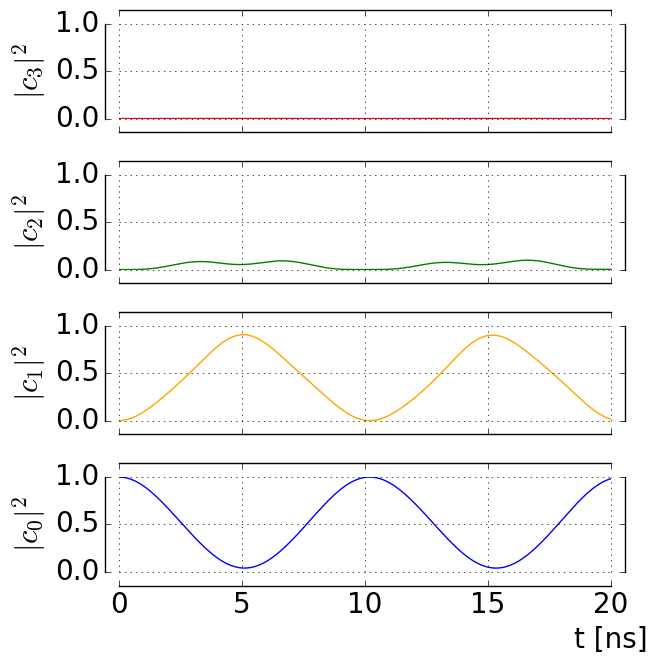

In [10]:
fig, axes = plt.subplots(nrows = 4, ncols=1, figsize=(7,7))

lines = [c0s, c1s, c2s, c3s]
colors = ["blue", "orange", "green", "red"]
for idx, cs, ax in zip(range(0, 4), lines, axes[::-1]):
    ax.plot(Ts, cs, color = colors[idx])
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    ax.set_ylim(0, 1)
    ax.grid()
    ax.set_yticks((0,.5,1))
    ax.set_ylabel("$|c_%i|^2$"%idx, fontsize=22)
    if idx > 0:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("t [ns]",position=(1,0))
#         ax.annotate("$f_q = %.2f$"%f_q, (0,0), xytext=(0,-0.75), textcoords="axes fraction")
plt.tight_layout()
# plt.savefig("tr_vstr_dr.pdf", format="pdf")

In [94]:
oper = qzero(2*N_q+1)
for _ in a.build_RWA_excitation_operator_list():
    oper += _[0]
oper

Quantum object: dims = [[15], [15]], shape = (15, 15), type = oper, isherm = True
Qobj data =
[[ 0.          1.31894615  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 1.31894615  0.         -1.82788809  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -1.82788809  0.          2.18783039  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          2.18783039  0.         -2.4587736   0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.         -2.4587736   0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          

In [74]:
a.build_RWA_excitation_operator_list()

[[Quantum object: dims = [[15], [15]], shape = (15, 15), type = oper, isherm = False
  Qobj data =
  [[ 0.          0.13189461  0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.          0.
     0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.          0.
     0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.          0.
     0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.          0.
     0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.          0.
     0.        ]
   [ 0.         